# Gaussian Process Regression in Pytorch

*Thomas Viehmann*, <tv@lernapparat.de>

Bayesian time!

I could not write a Gaussian Process introduction better than [Rasmussen and Williams in the canonical book](http://www.gaussianprocess.org/gpml/), so you will just follow the link.

This notebook touches selected aspects of Chapter 2 (Regression) and Section 5.4 (Model Selection for GP regression, we use the marginal likelihood).

As usual, the best part is that Pytorch will do the gradients for us.

(Note that the explanations are in no way finished.)

In [8]:
from matplotlib import pyplot
%matplotlib inline
import IPython
import torch
from torch import nn
from torch.autograd import Variable
import numpy

Let's have a very cheap cholesky layer.

If you want to be a hero, write a autograd triangular solve function. I think that would be both more efficient and more stable.

In [9]:
class Cholesky(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a):
        l = torch.potrf(a, False)
        ctx.save_for_backward(l)
        return l
    @staticmethod
    def backward(ctx, grad_output):
        l, = ctx.saved_variables
        # Gradient is l^{-H} @ ((l^{H} @ grad) * (tril(ones)-1/2*eye)) @ l^{-1}
        # TODO: ideally, this should use some form of solve triangular instead of inverse...
        linv =  l.inverse()
        
        inner = torch.tril(torch.mm(l.t(),grad_output))*torch.tril(1.0-Variable(l.data.new(l.size(1)).fill_(0.5).diag()))
        s = torch.mm(linv.t(), torch.mm(inner, linv))
        # could re-symmetrise 
        #s = (s+s.t())/2.0
        
        return s

So let's do Gaussian Process Regression. We use the basic RBF kernel but with automatic relevance detection and a gaussian likelihood (i.e. noisy data).


In [82]:
LOG2PI = numpy.log(2*numpy.pi)
class ARDRBFKernel(nn.Module):
    def __init__(self, n, lambda0=None, sigma0=None):
        super(ARDRBFKernel, self).__init__()
        self.n = n
        if lambda0 is None:
            lambda0 = torch.ones(n)*0.05
        self.lam = nn.Parameter(lambda0)
        if sigma0 is None:
            sigma0 = torch.ones(1)*0.1
        elif numpy.isscalar(sigma0):
            sigma0 = torch.FloatTensor(1).fill_(sigma0)
        self.sigma = nn.Parameter(sigma0)
    def forward(self, x, x2=None):
        # todo stabilize
        x = x/self.lam.unsqueeze(0).expand_as(x)
        if x2 is None:
            x2 = x
        else:
            x2 = x2/self.lam.unsqueeze(0).expand_as(x2)
        x_  = x.unsqueeze(1).expand(x.size(0),x2.size(0),x.size(1))
        x2_ = x2.unsqueeze(0).expand(x.size(0),x2.size(0),x.size(1))
        sqdists = ((x_-x2_)**2).sum(2) #.squeeze(2)
        return self.sigma.view(1,1).expand_as(sqdists)*(-sqdists/2).exp()

class GP(nn.Module):
    def __init__(self, K, x, y, var0=None):
        super(GP, self).__init__()
        if var0 is None:
            var0 = torch.ones(1)
        elif numpy.isscalar(var0):
            var0 = torch.FloatTensor(1).fill_(var0)
        self.var = nn.Parameter(var0)
        self.x = x
        self.y = y
        self.K = K
    def predict(self, xstar=None):
        Kxx_inv = torch.inverse(self.K(self.x)+Variable(torch.eye(self.x.size(0)))*self.var)
        Kxxstar = self.K(self.x, xstar)
        Kxstarxstar = self.K(xstar)
        mu = torch.mv(Kxxstar, torch.mv(Kxx_inv,self.y))
        cov = torch.Kxstarxstar-torch.mm(Kxxstar.t(), torch.mm(Kxx_inv), Kxxstar)
        return mu, cov
    def forward(self, xstar=None):
        Kxx_noise = self.K(self.x)+Variable(torch.eye(self.x.size(0)))*self.var
        L = Cholesky.apply(Kxx_noise)
        Linv = L.inverse()
        alpha = torch.mv(Kxx_noise.inverse(),self.y)
        if xstar is not None:
            Kxxstar = self.K(self.x, xstar)
            Kxstarxstar = self.K(xstar)
            mu = torch.mv(Kxxstar.t(), alpha)
            v = torch.mm(Linv,Kxxstar)
            cov = Kxstarxstar-torch.mm(v.t(),v)
        #print (self.K.lam.data[0], (0.5*self.y.dot(alpha)).data[0],L.diag().log().sum().data[0],self.y.size(0)/2.0*LOG2PI)
        neg_logp = 0.5*self.y.dot(alpha)+L.diag().log().sum()+self.y.size(0)/2.0*LOG2PI
        if xstar is not None:
            return mu,cov,neg_logp
        else:
            return neg_logp



Let's have a regression example

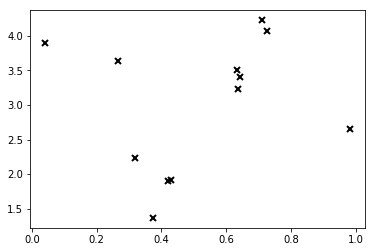

In [80]:
N = 12
X = torch.rand(N,1)
Y = (torch.sin(12*X) + 0.6*torch.cos(25*X) + torch.randn(N,1)*0.1 + 3).squeeze(1)
pyplot.figure()
pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)


In [89]:
K = ARDRBFKernel(1)
gp = GP(K, Variable(X), Variable(Y), var0=0.1)

def closure():
    opt.zero_grad()
    nlogp = gp.forward()
    nlogp.backward()
    return nlogp

opt = torch.optim.LBFGS(gp.parameters(), lr=0.1)
for i in range(10):
    opt.zero_grad()
    nlogp = gp.forward()
    nlogp.backward()
    opt.step(closure)
print ("Final loss",nlogp.data[0])

Final loss 15.55954647064209


And we can plot with the credible interval

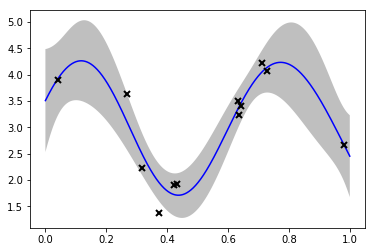

In [101]:
xstar = torch.linspace(0,1,1000)
mu, vsq, nll = gp.forward(xstar=Variable(xstar.unsqueeze(1)))
cred_size = vsq.diag()**0.5*2
pyplot.plot(xstar.numpy(),mu.data.numpy(),'b')
pyplot.fill_between(xstar.numpy(),mu.data.numpy()+cred_size.data.numpy(), mu.data.numpy()-cred_size.data.numpy(),facecolor='0.75')
pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)



I appreciate your feedback at <tv@lernapparat.de>.